# England 2020-2021

In [2]:
import pandas as pd
import numpy as np

# Note: requires installation of odfpy and feather-format


## Community Life Survey

- Community Life Survey is household self completion study conducted every year by DCSM 
- Asks 1 direct and 3 indirect questions on loneliness 
- The raw data is not published, only qual summaries
- However there is an ad-hoc release - Community Life Survey: Strength of community variables by Output Area Classification, 2017/18 to 2020/21 
- https://www.gov.uk/government/statistical-data-sets/dcms-community-life-survey-ad-hoc-statistical-releases
- Data only provided for the one direct question of loneliness
- This isolates 2020/21 and maps the results to LSOA 
- Numbers represent responses of "Often/always & some of the time" to "How often do you feel lonely?"

In [3]:
# Read loneliness sheet of community life survey for 2020/21
df = pd.read_excel("cls.ods",  engine="odf", sheet_name = "A6", skiprows = 26, nrows =1)

In [4]:
df.drop(columns=df.columns[:3], axis=1, inplace=True)

In [5]:
df = (df.T).reset_index()
df.rename(columns = {"index": "oac_11", 0: "perc" }, inplace = True)
df.drop(index=df.index[-1],axis=0,inplace=True)

In [6]:
df['oac_11'] = df.oac_11.str[-2:]

In [7]:
# No data for one of the OACs
# Replace no value with 0
df.loc[19, 'perc'] = 0

In [17]:
df.head(2)

,oac_11,perc
0,1a,18.996752
1,1b,23.092455


 Length of df: 26


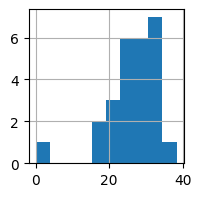

In [15]:
print(f" Length of df: {len(df)}")
df.perc.hist(figsize = (2,2));

## Join OAC to OA

- Data is analysed by the 26 groups of the 2011 Area Classification for Output Areas which groups areas with similar characteristics
- Lookup for OAC '11 TO OA'11 is here https://www.ons.gov.uk/methodology/geography/geographicalproducts/areaclassifications/2011areaclassifications/datasets

In [18]:
# Read csv to join OAC to OA
oa = pd.read_csv("oac_lookup.csv")
oa = oa[["Output Area Code", "Group Code"]]
oa.rename(columns = {"Group Code": "oac_11", "Output Area Code":"oa11_code"}, inplace = True )

In [19]:
# Join to loneliness perc
df_oa = oa.merge(df, on = 'oac_11', how = 'left')

In [22]:
# Check
print(oa.oa11_code.nunique() == df_oa.oa11_code.nunique())
print(f" Length of df_oa: {len(df_oa)}")

True
 Length of df_oa: 232296


## Join OA11 to LSOA 11

In [24]:
# Read file from geographr to join OA 11 to LSOA 11
lookup_11 = pd.read_feather("../../extdata/lookup_11.feather")
lookup_11 = lookup_11[['lsoa11_code','oa11_code']]
df_lsoa11 = lookup_11.merge(df_oa, on = 'oa11_code', how = 'left')

In [25]:
# Drop NAs as not all LSOAs in lookup_11 are in England
df_lsoa11['perc'].dropna(inplace = True)

In [26]:
# Get average of each LSOA
df_lsoa11.perc = df_lsoa11.perc.astype(float)
df_lsoa11 = df_lsoa11.groupby(['lsoa11_code'], as_index = False)['perc'].mean()

In [28]:
print(df_lsoa11.lsoa11_code.nunique() == lookup_11.lsoa11_code.nunique())
print(f" Length of df_oa: {len(df_lsoa11)}")

True
 Length of df_oa: 41729


## Join LSOA 11 to LSOA 21

In [29]:
# Read file from geographr to join lsoa 11 code to lsoa 21 code 
lookup_21 = pd.read_feather("../../extdata/lookup_21.feather")
lookup_21 = lookup_21[["lsoa11_code", "lsoa21_code"]]
loneliness = df_lsoa11.merge(lookup_21, on = "lsoa11_code", how = "left")

In [30]:
loneliness = loneliness[["lsoa21_code", "perc"]]

In [31]:
loneliness = loneliness.groupby("lsoa21_code", as_index = False).mean()

In [32]:
loneliness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lsoa21_code  35672 non-null  object 
 1   perc         35672 non-null  float64
dtypes: float64(1), object(1)
memory usage: 557.5+ KB


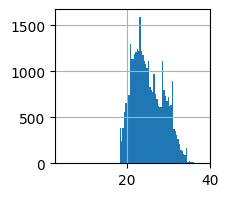

In [34]:
loneliness.perc.hist(bins = 100, figsize = (2,2));

In [35]:
print(lookup_21['lsoa21_code'].nunique() == loneliness.lsoa21_code.nunique())
print(f" Length of df_oa: {len(loneliness)}")

True
 Length of df_oa: 35672


In [36]:
loneliness.sample(5)

,lsoa21_code,perc
20295,E01021369,27.580243
6140,E01006460,30.353882
32495,E01034457,20.697078
30984,E01032649,30.489330
6700,E01007056,22.504693


In [155]:
loneliness.to_csv("../../extdata/england_cls_2020_2021.csv", index = False )